In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

train_dir_preupdate = '/content/gdrive/My Drive/Machine Learning/train_images/' #@param {type:"string"}
whole_train_dir = '/content/gdrive/My Drive/Machine Learning/train_images_he/' #@param {type:"string"}
val_train_dir = '/content/gdrive/My Drive/Machine Learning/val_train_images/' #@param {type:"string"}
dec_train_dir = '/content/gdrive/My Drive/Machine Learning/dec_train_images/' #@param {type:"string"}

test_dir_preupdate = '/content/gdrive/My Drive/Machine Learning/test/test_images/' #@param {type:"string"}
test_dir = '/content/gdrive/My Drive/Machine Learning/test/he/' #@param {type:"string"}

whole_label_csv = '/content/gdrive/My Drive/Machine Learning/labels_train.csv' #@param {type:"string"}
val_csv = '/content/gdrive/My Drive/Machine Learning/val_labels_train.csv' #@param {type:"string"}
dec_csv = '/content/gdrive/My Drive/Machine Learning/train_labels.csv' #@param {type:"string"}
test_csv = '/content/gdrive/MyDrive/Machine Learning/sample_submission.csv' #@param {type:"string"}

wholedf = pd.read_csv(whole_label_csv, dtype=str)
valdf = pd.read_csv(val_csv, dtype=str)
decdf = pd.read_csv(dec_csv, dtype=str)
testdf = pd.read_csv(test_csv, dtype=str)


MODEL_HYPERPARAMS = {
    'xception':{
        'epochs': 80,
        'img_size':300,
        'batch_size':32,
        'fine-tune_epochs':100,
        'fine_tune_initial-unfrozen-layer':689
    },
    'efficientnet3':{
        'epochs':40,
        'img_size':300,
        'batch_size':64,
        'fine-tune_epochs':70,
        'fine_tune_initial-unfrozen-layer':290
    },
    'efficientnet3_v2':{
        'epochs':40,
        'img_size':300,
        'batch_size':32,
        'fine-tune_epochs':80,
        'fine_tune_initial-unfrozen-layer':320
    },
    'efficientnet4':{
        'img_size':300,
        'epochs':50,
        'batch_size':16,
        'fine-tune_epochs':80,
        'fine_tune_initial-unfrozen-layer':322
    },
    'efficientnet7':{
        'epochs':50,
        'batch_size':8,
        'img_size':300,
        'fine-tune_epochs':80,
        'fine_tune_initial-unfrozen-layer':719
    }
}

CHOSEN_MODEL = 'efficientnet3_v2' #@param ["xception","efficientnet3","efficientnet3_v2", "efficientnet4", "efficientnet7"]
IMG_SIZE = MODEL_HYPERPARAMS[CHOSEN_MODEL]['img_size']
EPOCHS = MODEL_HYPERPARAMS[CHOSEN_MODEL]['epochs']
FINE_TUNE_EPOCHS = MODEL_HYPERPARAMS[CHOSEN_MODEL]['fine-tune_epochs']
BATCH_SIZE = MODEL_HYPERPARAMS[CHOSEN_MODEL]['batch_size']
INITIAL_UNFROZEN_LAYER = MODEL_HYPERPARAMS[CHOSEN_MODEL]['fine_tune_initial-unfrozen-layer']

Mounted at /content/gdrive


# Pray for a juicy Tesla T4

In [ ]:
!nvidia-smi

Sat Jan 30 00:21:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Split Train - Validation Datasets

In [ ]:
from csv import writer
import os
import shutil


def cross_val(total_val_images):
    '''
    We seperate our dataset into 2 parts: 
      1. Decreased Training Set
      2. Validation Training Set

    For each part, a new folder for the images and a new csv for the labels are generated.
    '''
    try:
        os.mkdir(val_train_dir)
        os.mkdir(dec_train_dir)
    except:
        pass
    with open(val_csv, mode='w') as val_csvfile:
        val_writer = writer(val_csvfile)
        val_writer.writerow(['file_name', 'class_id'])
        with open(dec_csv, mode='w') as dec_csvfile:
            dec_writer = writer(dec_csvfile)
            dec_writer.writerow(['file_name', 'class_id'])
            with open(whole_label_csv, mode='r') as csvfile:
                for i, row in wholedf.iterrows():
                    if (i < total_val_images):
                        # shutil.copy(whole_train_dir+row['file_name'], val_train_dir)
                        val_writer.writerow(
                            [row['file_name'], row['class_id']])
                    else:
                        # shutil.copy(train_dir+row['file_name'], dec_train_dir)
                        dec_writer.writerow(
                            [row['file_name'], row['class_id']])

# Training set consists of 4672 images. we use 20% of those (934) for validation.
VAL_IMAGES = 934 #@param {type:"integer"}
cross_val(VAL_IMAGES) 


# Image Resize

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


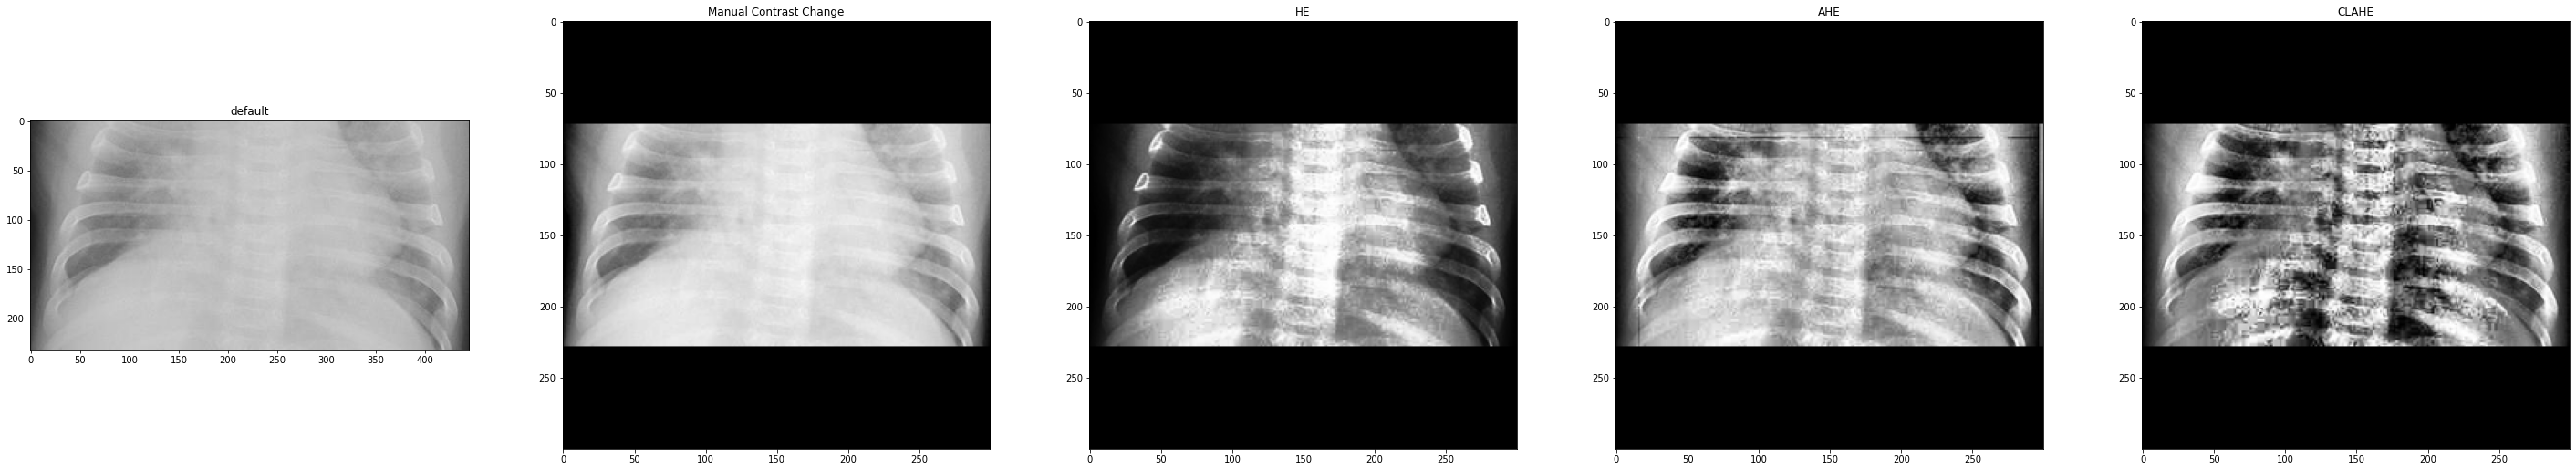

In [ ]:
from PIL import Image, ImageOps
import cv2
from skimage import exposure
from keras.layers import *
import numpy as np
import matplotlib.pyplot as plt

def change_contrast(img):  # Simple Contrast Change
    def contrast(c):
        return 128 + factor * (c - 128)
    level = 50
    factor = (259 * (level + 255)) / (255 * (259 - level))
    return img.point(contrast)


def HE(img):  # Histogram Equalization
    img = np.array(img)

    img = exposure.equalize_hist(img, mask=None)
    img = Image.fromarray((img * 255).astype(np.uint8))
    return img


def AHE(img):  # Adaptive Histogram Equalization
    img = np.array(img)
    img = exposure.equalize_adapthist(img, clip_limit=0.03)
    img = Image.fromarray((img * 255).astype(np.uint8))
    return img


def CLAHE(img):  # Contrast Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=250)
    try:
        im = clahe.apply(np.array(img)[:, :, 0])
    except:
        im = clahe.apply(np.array(img))
    im = Image.fromarray(np.uint8(im))
    return im


def get_preproccessed_image(file_name, preprocess_func):
  '''
  Creates the final preprocessed image.
  Adds padding (black bars) in order to keep the original ratio.
  '''
  im = Image.open(file_name)
  old_size = im.size
  ratio = float(IMG_SIZE)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  im = preprocess_func(im)

  im = im.resize(new_size, Image.ANTIALIAS)

  new_im = Image.new("RGB", (IMG_SIZE, IMG_SIZE))
  new_im.paste(im, ((IMG_SIZE-new_size[0])//2,
                    (IMG_SIZE-new_size[1])//2))
  return new_im


def resize_ds(train_save, test_save, preprocess_func):
    try:
        os.mkdir(train_save)
        os.mkdir(test_save)
    except:
        pass
    for i, row in wholedf.iterrows():
        print("train_dir index: ", i)
        img = get_preproccessed_image(train_dir_preupdate+row['file_name'], preprocess_func)
        img.save(train_save+row['file_name'])
    for i, row in testdf.iterrows():
        print("test_dir index: ", i)
        img = get_preproccessed_image(
            test_dir_preupdate+row['file_name'], preprocess_func)
        img.save(test_save+row['file_name'])


def plot_sample(sample='img_8363418452287736649.jpg'):
    images = [
        {
            'name': 'default',
            'img': Image.open(train_dir_preupdate+sample).convert('LA')
        },
        {
            'name': 'Manual Contrast Change',
            'img': get_preproccessed_image(train_dir_preupdate+sample, change_contrast)
        },
        {
            'name': 'HE',
            'img': get_preproccessed_image(train_dir_preupdate+sample, HE)
        },
        {
            'name': 'AHE',
            'img': get_preproccessed_image(train_dir_preupdate+sample, AHE)
        },
        {
            'name': 'CLAHE',
            'img': get_preproccessed_image(train_dir_preupdate+sample, CLAHE)
        },
    ]
    plt.figure(figsize=(50, 50))

    for i, image in enumerate(images):
        plt.subplot(5, 5, i+1, title=image['name'])
        plt.imshow(image['img'])

    plt.show()


plot_sample()
# Best Results with HE
resize_ds(whole_train_dir,test_dir,HE)


# Train - Test Generators

In [ ]:
import cv2
import types 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30, #@param {type:"integer"},
                                   width_shift_range=0.05, #@param {type:"float"},
                                   height_shift_range=0.05, #@param {type:"integer"},
                                   zoom_range=0.1, #@param {type:"integer"},
                                   brightness_range=[0.2,1], #@param {type:"array"},
                                   shear_range=0.05, #@param {type:"integer"},
                                   horizontal_flip = True,
                                   fill_mode='nearest')

train_generator=train_datagen.flow_from_dataframe(
dataframe=decdf,
directory=dec_train_dir,
x_col="file_name",
y_col="class_id",
batch_size=BATCH_SIZE,
color_mode="rgb",
shuffle=True,
class_mode="categorical",
save_format="jpeg",
seed=69,
target_size=(IMG_SIZE,IMG_SIZE))


test_datagen=ImageDataGenerator(rescale=1.0/255.0,fill_mode="nearest")

val_generator=test_datagen.flow_from_dataframe(
dataframe=valdf,
directory=val_train_dir,
x_col="file_name",
y_col="class_id",
batch_size=2,
color_mode="rgb",
class_mode="categorical",
shuffle=False,
save_format="jpeg",
target_size=(IMG_SIZE,IMG_SIZE),
)

test_generator=test_datagen.flow_from_dataframe(
  dataframe=testdf,
  directory=test_dir,
  x_col="file_name",
  y_col=None,
  batch_size=2,
  color_mode="rgb",
  shuffle=False,
  class_mode=None,
  save_format="jpeg",
  target_size=(IMG_SIZE,IMG_SIZE)
)

Found 3738 validated image filenames belonging to 3 classes.
Found 934 validated image filenames belonging to 3 classes.
Found 1168 validated image filenames.


## Plot Augmentation Sample

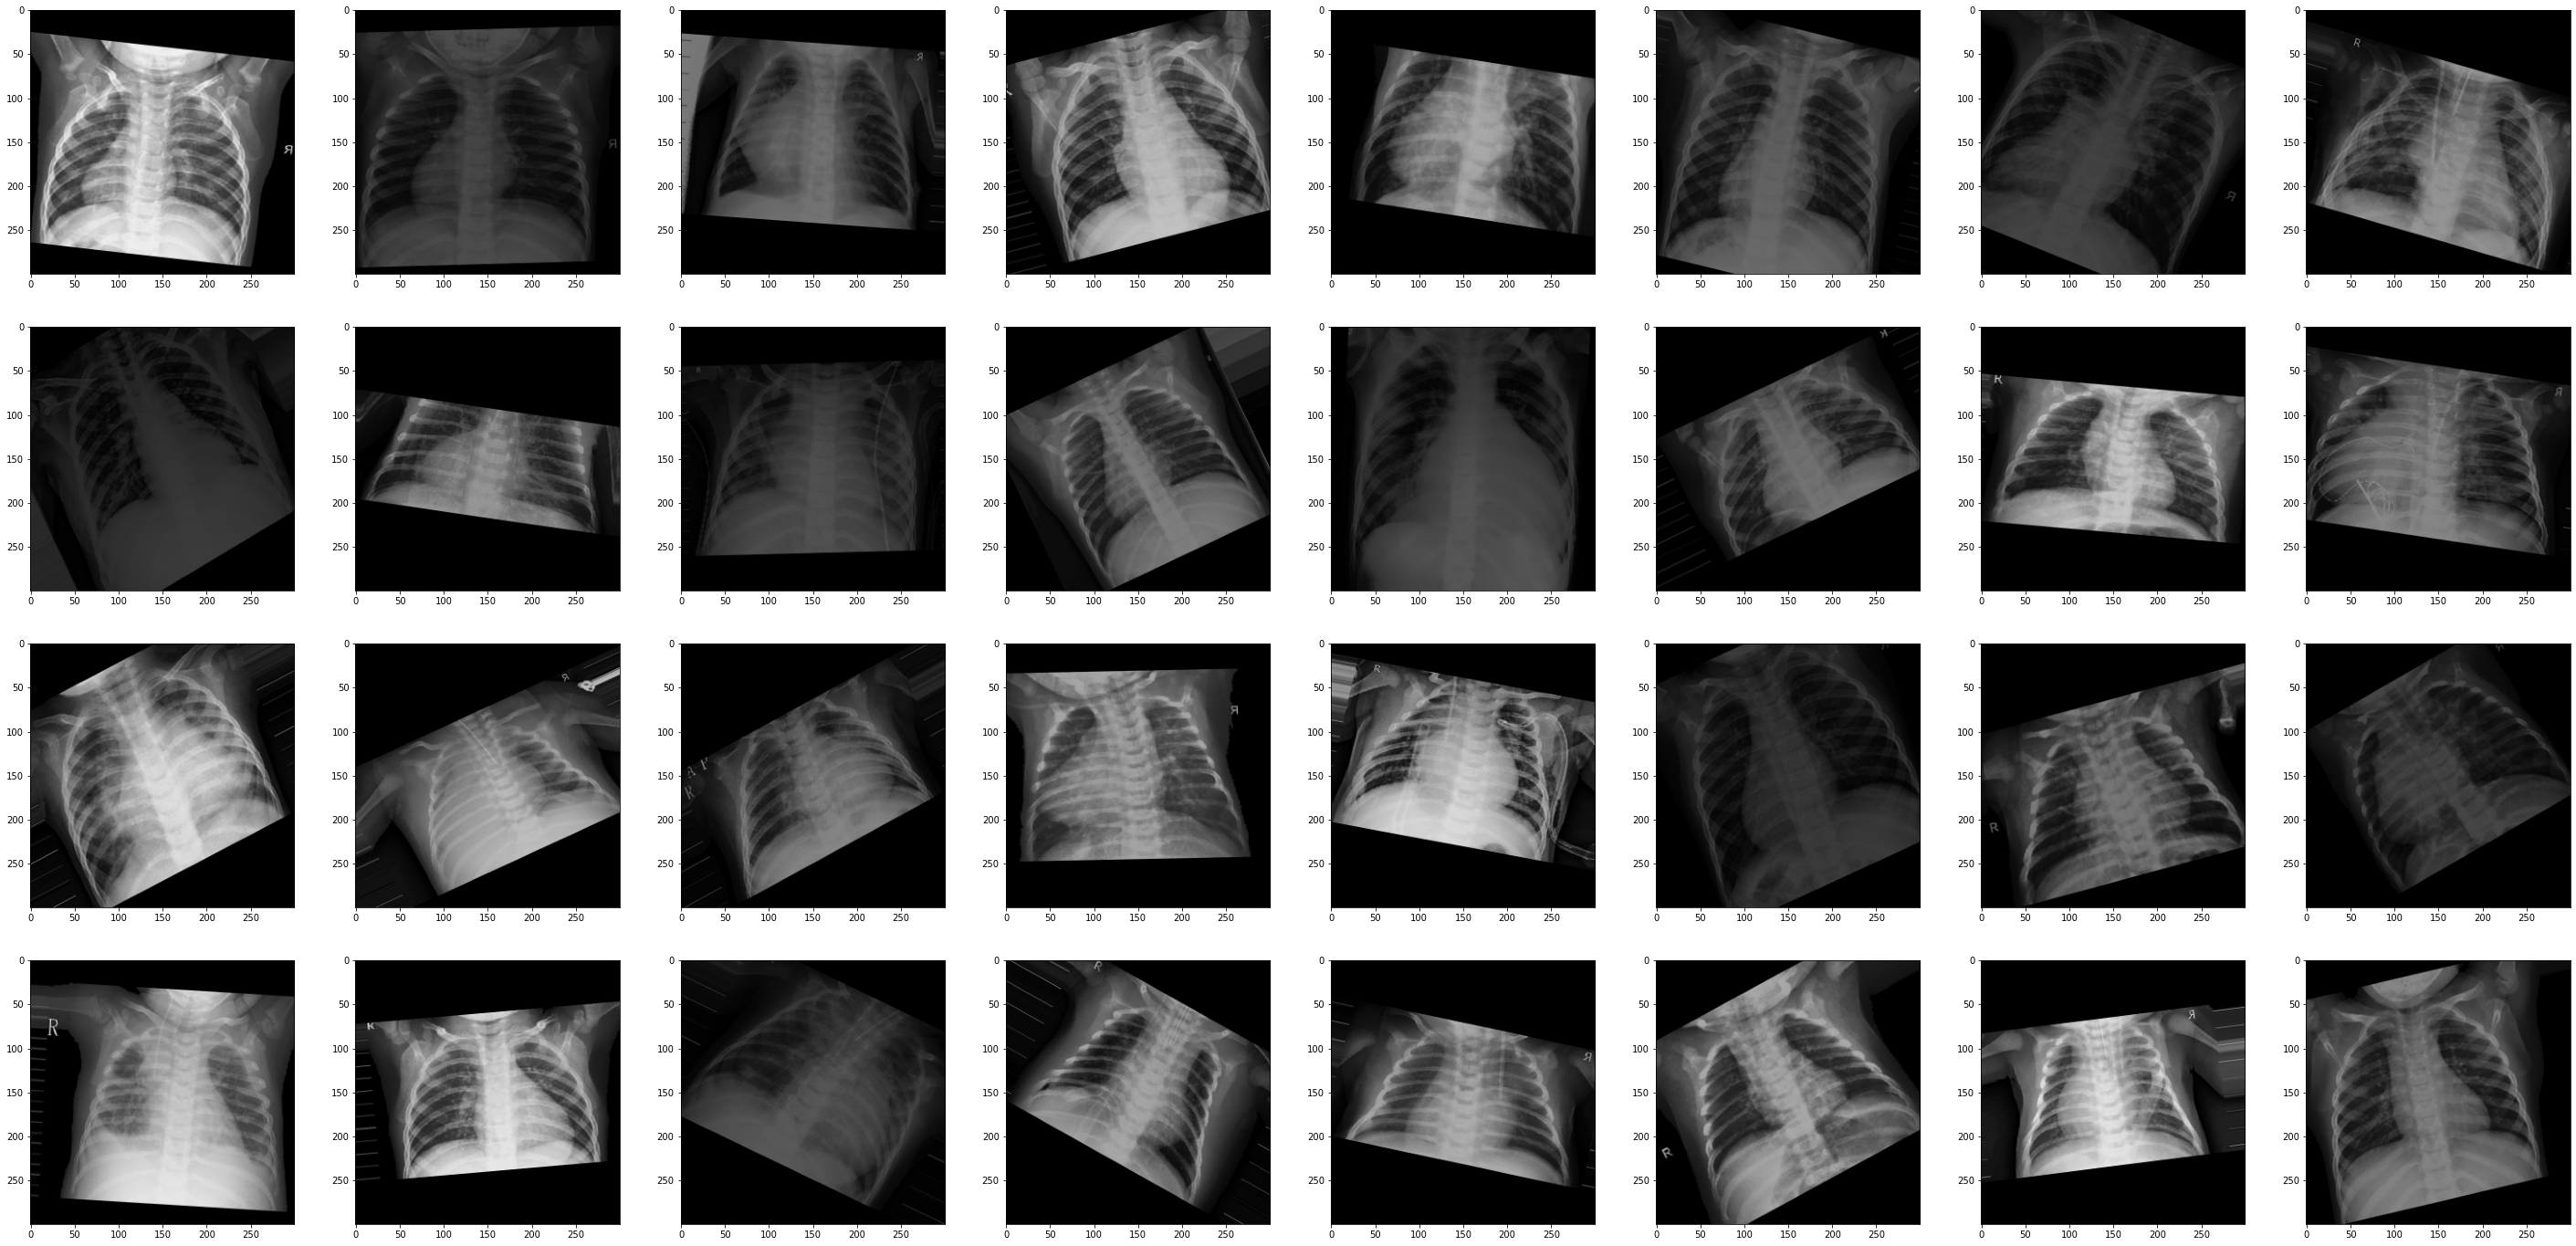

In [ ]:
def plot_data_augmentation_sample():
  plt.figure(figsize=(50, 50))
  x,y = train_generator.next()
  for i, image in enumerate(x):
      plt.subplot(BATCH_SIZE/4, BATCH_SIZE/4, i+1)
      plt.imshow(x[i])

  plt.show()
plot_data_augmentation_sample()

# Pre-trained Models

In [ ]:
!pip install efficientnet
from keras import optimizers, losses
from keras.utils import to_categorical, plot_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from keras.models import Model
import efficientnet.keras as efn
from tensorflow.keras.layers import *


def efficientNetB7():
        baseModel = efn.EfficientNetB7(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        headModel = baseModel.output
        headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation="relu")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        headModel = Dense(128, activation="relu")(headModel)
        headModel = Dense(64, activation="relu")(headModel)
        headModel = Dropout(0.2)(headModel)
        headModel = Dense(3, activation="softmax")(headModel)

        model = Model(inputs=baseModel.input, outputs=headModel)

        for layer in baseModel.layers:
            layer.trainable = False

        return model

def efficientNetB3():
        baseModel = efn.EfficientNetB3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        headModel = baseModel.output
        headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation="relu")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        headModel = Dense(128, activation="relu")(headModel)
        headModel = Dense(64, activation="relu")(headModel)
        headModel = Dropout(0.3)(headModel)
        headModel = Dense(3, activation="softmax")(headModel)

        model = Model(inputs=baseModel.input, outputs=headModel)

        for layer in baseModel.layers:
            layer.trainable = False

        return model

def efficientNetB3_V2():
        baseModel = efn.EfficientNetB3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        headModel = baseModel.output
        headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation="relu")(headModel)
        headModel = Dropout(0.2)(headModel)
        headModel = Dense(3, activation="softmax")(headModel)
        model = Model(inputs=baseModel.input, outputs=headModel)

        for layer in baseModel.layers:
            layer.trainable = False

        return model

def efficientNetB4():
        baseModel = efn.EfficientNetB4(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        headModel = baseModel.output
        headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation="relu")(headModel)
        headModel = Dropout(0.2)(headModel)
        headModel = Dense(3, activation="softmax")(headModel)
        model = Model(inputs=baseModel.input, outputs=headModel)

        for layer in baseModel.layers:
            layer.trainable = False

        return model

def XceptionM():
        baseModel = efn.EfficientNetB7(
            weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        headModel = baseModel.output
        headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
        headModel = BatchNormalization()(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(512, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(3, activation="softmax")(headModel)
        print(len(baseModel.layers))

        model = Model(inputs=baseModel.input, outputs=headModel)

        for layer in baseModel.layers:
            layer.trainable = False

        return model




     |████████████████████████████████| 51kB 8.1MB/s 


# Model Setup

- Use Learning rate scheduler based on current epoch. 
- Reduce learning rate on validation loss plateau.
- Adam as optimizer with a learning rate of 1e-3 and 1e-4 decay

In [ ]:
# Learning Rate
from keras import optimizers
import tensorflow as tf



def lr_schedule(epoch):
    lr = 1e-3
    if epoch > EPOCHS//1.2:
        lr *= 0.5e-3
    elif epoch > EPOCHS//1.5:
        lr *= 1e-3
    elif epoch > EPOCHS//2:
        lr *= 1e-2
    elif epoch > EPOCHS//3:
        lr *= 1e-1
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.3,
                                                  mode='min',
                                                  patience=3,
                                                  min_lr=0.0000001,
                                                  verbose=1)

if (CHOSEN_MODEL == 'xception'):
  model = XceptionM()
elif (CHOSEN_MODEL == 'efficientnet3'):
  model = efficientNetB3()
elif (CHOSEN_MODEL == 'efficientnet4'):
  model = efficientNetB4()
elif (CHOSEN_MODEL == 'efficientnet3_v2'):
  model = efficientNetB3_V2()
elif (CHOSEN_MODEL == 'efficientnet7'):
  model = efficientNetB7()
 

model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(1e-3, decay=1e-4),
              metrics=['acc'])

SUBMIT_NAME = f"{CHOSEN_MODEL}_S-{IMG_SIZE}_HE"

44113920/44107200 [==============================] - 0s 0us/step


# Checkpoints

In [ ]:
# Checkpoints
from keras.callbacks import *
import os 

checkpoint_path = "/content/gdrive/My Drive/Machine Learning/"+SUBMIT_NAME+"/"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 monitor='val_acc',
                                                 verbose=1)


# Utility Functions: Plot Results, Show Validation metrics

In [ ]:
from sklearn.metrics import classification_report

def history_peak_epoch(history, metric, metric_type):
  '''
  Returns the best epoch based on given metric.
  '''
  if (metric_type == 'min'):
      peak = history.history[metric].index(min(history.history[metric]))
  else:
      peak = history.history[metric].index(max(history.history[metric]))
  return peak


def plot_history(history, metrics, primary_metric,primary_metric_type):
  '''
  Plots history metrics.
  '''
  peak = history_peak_epoch(history,primary_metric,primary_metric_type)
  plt.figure(figsize=(10, 8))
  for metric in metrics:
      plt.plot(history.history[metric])
  plt.title(f'Peak at epoch: {peak}')
  plt.xlabel('Epochs')
  plt.ylabel('%')
  plt.legend(metrics)
  plt.grid(b=True)
  plt.show()


def validation_metrics(model,val_generator):
  '''
  For each class, prints the total wrongly predictied classes.
  Also prints classification report from sklearn. 
  '''

  Y_test = np.array(valdf['class_id'])
  y_pred = model.predict(val_generator)
  predicted_class_indices = np.argmax(y_pred, axis=1)

  labels = (train_generator.class_indices)
  labels = dict((v, k) for k, v in labels.items())
  predictions = [labels[k] for k in predicted_class_indices]


  wrong_predictions = np.zeros([3,3])

  for index,prediction in enumerate(predictions):
    true_value = int(Y_test[index])
    prediction = int(prediction)
    if prediction != true_value:
      wrong_predictions[prediction,true_value]+=1

  print('Displaying wrong predictions per class.')
  for pneumonia_class in range(3):
    print(f'Wrong predictions for class {pneumonia_class}')
    for index,wrong_prediction_per_class in enumerate(wrong_predictions[pneumonia_class,:]):
      if (wrong_prediction_per_class):
        print(f'Total Images classified wrongly as {index} : {wrong_prediction_per_class}')
    print('----')

In [ ]:
from sklearn.utils import class_weight
def get_class_weights():
  y_train = wholedf.to_numpy()[:, 1]
  class_weights = class_weight.compute_class_weight('balanced',
                                                    np.unique(y_train),
                                                    y_train)
  class_weights = {
      0: class_weights[0],
      1: class_weights[1],
      2: class_weights[2],
  }
  return class_weights

# RUN: TRAIN TOP LAYERS & FINE TUNE

## TRAIN TOP LAYERS

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size

history_train_top = model.fit(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=EPOCHS,
                              callbacks=[lr_reducer, lr_scheduler, cp_callback],)

plot_history(history_train_top,['acc','val_acc'],'val_acc','max')
validation_metrics(model,val_generator)

Epoch 1/40
116/116 [==============================] - 1263s 11s/step - loss: 5.3820 - acc: 0.5757 - val_loss: 0.6980 - val_acc: 0.6874

Epoch 00001: val_acc improved from -inf to 0.68737, saving model to /content/gdrive/My Drive/Machine Learning/efficientnet3_v2_S-300_HE/
Epoch 2/40
116/116 [==============================] - 106s 912ms/step - loss: 0.6541 - acc: 0.7012 - val_loss: 0.6053 - val_acc: 0.7120

Epoch 00002: val_acc improved from 0.68737 to 0.71199, saving model to /content/gdrive/My Drive/Machine Learning/efficientnet3_v2_S-300_HE/
Epoch 3/40
116/116 [==============================] - 106s 909ms/step - loss: 0.6158 - acc: 0.7297 - val_loss: 0.7127 - val_acc: 0.6927

Epoch 00003: val_acc did not improve from 0.71199
Epoch 4/40
116/116 [==============================] - 105s 903ms/step - loss: 0.5940 - acc: 0.7437 - val_loss: 0.5251 - val_acc: 0.7741

Epoch 00004: val_acc improved from 0.71199 to 0.77409, saving model to /content/gdrive/My Drive/Machine Learning/efficientnet3

KeyboardInterrupt: ignored

## FINE TUNE

In [ ]:
for i, layer in enumerate(model.layers):
 print(i, layer.name)

In [ ]:
if (INITIAL_UNFROZEN_LAYER):
  for layer in model.layers[:INITIAL_UNFROZEN_LAYER ]:
      layer.trainable = False
  for layer in model.layers[INITIAL_UNFROZEN_LAYER:]:
      layer.trainable = True

  model.compile(loss="categorical_crossentropy",
                optimizer=optimizers.Adam(lr=1e-6),
                metrics=['acc'])
  STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size

  history = model.fit(train_generator,
                      validation_data=val_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      epochs=FINE_TUNE_EPOCHS,
                      callbacks=[lr_reducer, lr_scheduler, cp_callback])

plot_history(history,['acc','val_acc'],'val_acc','max')
validation_metrics(model,val_generator)

Epoch 1/80
116/116 [==============================] - 117s 940ms/step - loss: 0.8790 - acc: 0.6844 - val_loss: 0.8341 - val_acc: 0.6756

Epoch 00001: val_acc did not improve from 0.82548
Epoch 2/80
116/116 [==============================] - 107s 924ms/step - loss: 0.5469 - acc: 0.7768 - val_loss: 0.6196 - val_acc: 0.7409

Epoch 00002: val_acc did not improve from 0.82548
Epoch 3/80
116/116 [==============================] - 107s 923ms/step - loss: 0.5632 - acc: 0.7702 - val_loss: 0.5210 - val_acc: 0.7666

Epoch 00003: val_acc did not improve from 0.82548
Epoch 4/80
116/116 [==============================] - 107s 919ms/step - loss: 0.5449 - acc: 0.7897 - val_loss: 4.3891 - val_acc: 0.6296

Epoch 00004: val_acc did not improve from 0.82548
Epoch 5/80
116/116 [==============================] - 107s 920ms/step - loss: 0.5368 - acc: 0.7748 - val_loss: 0.4313 - val_acc: 0.8191

Epoch 00005: val_acc did not improve from 0.82548
Epoch 6/80
116/116 [==============================] - 107s 922ms/

NameError: ignored

# Load Best Weights

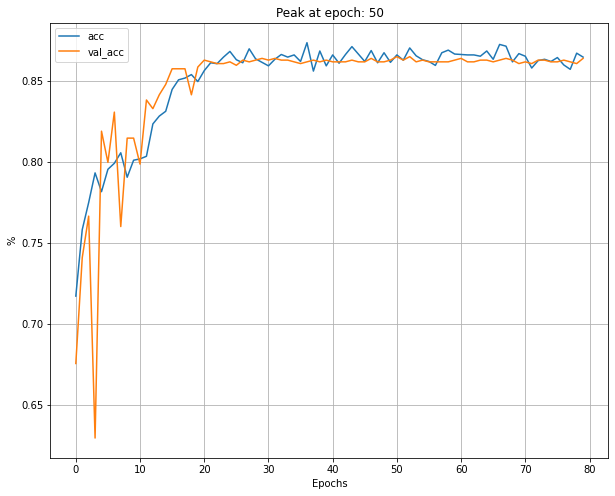

Displaying wrong predictions per class.
Wrong predictions for class 0
Total Images classified wrongly as 1 : 4.0
Total Images classified wrongly as 2 : 5.0
----
Wrong predictions for class 1
Total Images classified wrongly as 0 : 1.0
Total Images classified wrongly as 2 : 63.0
----
Wrong predictions for class 2
Total Images classified wrongly as 0 : 8.0
Total Images classified wrongly as 1 : 46.0
----


In [ ]:
plot_history(history,['acc','val_acc'],'val_acc','max')
validation_metrics(model,val_generator)

In [ ]:
model.load_weights(checkpoint_path)

# Compute validation metrics per class

# Predict

In [ ]:
def submit_predictions():
    softmax = model.predict(test_generator, verbose=1)
    predicted_class_indices = np.argmax(softmax, axis=1)

    # Generator class dictionary mapping
    labels = (train_generator.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]

    results = pd.DataFrame(
        {"file_name": test_generator.filenames, "class_id": predictions})
    results.to_csv(checkpoint_path+SUBMIT_NAME+".csv", index=False)
    softmax_results = pd.DataFrame(softmax)
    softmax_results.to_csv(checkpoint_path+SUBMIT_NAME +
                           "__softmax.csv", index=False)


submit_predictions()


In [ ]:
def commitee_trust_vote():
    '''
    Commitee softmax voting implementation.
    Softmax outputs of each model are summed.
    Final prediction is the class with the highest score. 
     '''
    elite_folder = '/content/gdrive/MyDrive/Machine Learning/commitees/softmax_votes'
    elites = os.listdir(elite_folder)
    elite_predictions = np.zeros([test_generator.n, 3])
    for elite_csv in elites:
        predictions = pd.read_csv(elite_folder+'/'+elite_csv, dtype=float)
        elite_predictions = np.sum([elite_predictions, predictions], axis=0)

    predicted_class_indices = np.argmax(elite_predictions, axis=1)
    labels = (train_generator.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]

    results = pd.DataFrame(
        {"file_name": test_generator.filenames, "class_id": predictions})
    results.to_csv(
        f'/content/gdrive/MyDrive/Machine Learning/commitees/commitee_trust-softmax.csv', index=False)

commitee_trust_vote()


In [ ]:
def commitee_vote():
    '''
    Commitee voting implementation.
    Votes folder consists of csv prediction files.
    Each line is an image and a prediction.
    For each line, construct an array and read every model prediction.
    Each array index maps to a class, therefore we ++ the value of the index based on the read prediction.
    Final prediction is the index of the class with the most predictions.  
    '''
    commitee_folder = '/content/gdrive/MyDrive/Machine Learning/commitees/votes'
    commitees = os.listdir(commitee_folder)
    commitee_predictions = []
    for i in range(test_generator.n):
        votes = np.zeros(len(commitees))
        for commitee_csv in commitees:
            commiteedf = pd.read_csv(
                commitee_folder+'/'+commitee_csv, dtype=str)
            vote_index = int(commiteedf['class_id'][i])
            votes[vote_index] += 1

        winner_class = np.where(votes == max(votes))
        commitee_predictions.append(winner_class[0][0])

    results = pd.DataFrame(
        {"file_name": test_generator.filenames, "class_id": commitee_predictions})
    results.to_csv(
        f'/content/gdrive/MyDrive/Machine Learning/commitees/commitee_votes_5.csv', index=False)

commitee_vote()
